In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.

most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(f"The most recent date in the dataset is: {most_recent_date}")


The most recent date in the dataset is: 2017-08-23


The date 12 months prior to the most recent date is: 2016-08-23 00:00:00


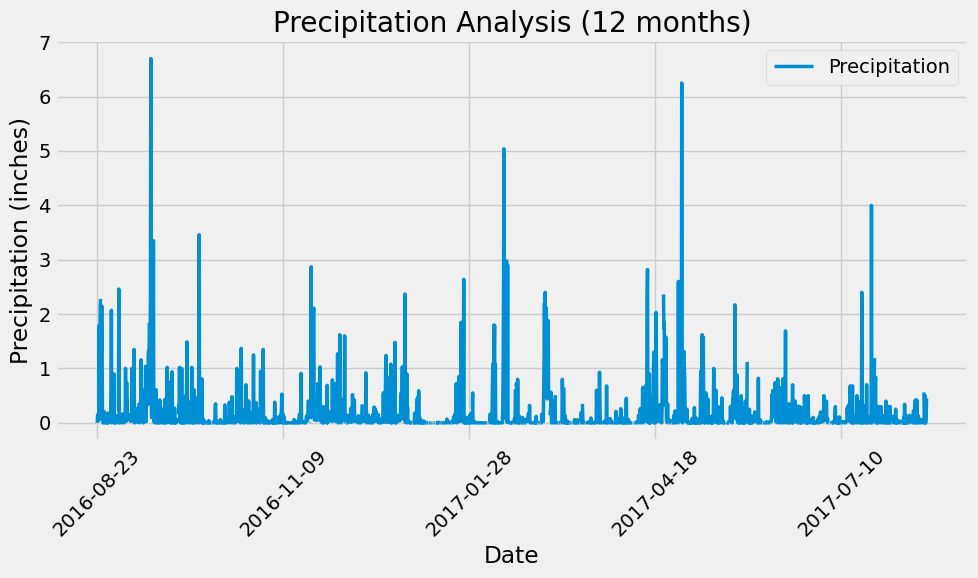

In [20]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago_date = pd.to_datetime(most_recent_date) - pd.DateOffset(months=12)
print(f"The date 12 months prior to the most recent date is: {one_year_ago_date}")

# Perform a query to retrieve the data and precipitation scores
# Convert the date to a string representation
one_year_ago_date_str = one_year_ago_date.strftime('%Y-%m-%d')

# Query the previous 12 months of precipitation data
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
                        .filter(Measurement.date >= one_year_ago_date_str)\
                        .filter(Measurement.date <= most_recent_date)\
                        .order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names

precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Set the 'Date' column as the index
precipitation_df.set_index('Date', inplace=True)


# Sort the dataframe by date

precipitation_df.sort_index(inplace=True)


# Use Pandas Plotting with Matplotlib to plot the data

precipitation_df.plot(kind='line', figsize=(10, 6), rot=45, legend=True, linewidth=2.5)
plt.title("Precipitation Analysis (12 months)")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.tight_layout()
plt.show()


In [21]:
# Use Pandas to calculate the summary statistics for the precipitation data

print(precipitation_df.describe())


       Precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [22]:
# Design a query to calculate the total number of stations in the dataset

total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")


Total number of stations: 9


In [23]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                                .group_by(Measurement.station)\
                                .order_by(func.count(Measurement.station).desc()).all()

print("Most-active stations (in descending order):")
for station in most_active_stations:
    print(f"Station ID: {station[0]}, Observation Count: {station[1]}")

# The station with the greatest number of observations
most_active_station_id = most_active_stations[0][0]
print(f"\nStation ID with the greatest number of observations: {most_active_station_id}")


Most-active stations (in descending order):
Station ID: USC00519281, Observation Count: 2772
Station ID: USC00519397, Observation Count: 2724
Station ID: USC00513117, Observation Count: 2709
Station ID: USC00519523, Observation Count: 2669
Station ID: USC00516128, Observation Count: 2612
Station ID: USC00514830, Observation Count: 2202
Station ID: USC00511918, Observation Count: 1979
Station ID: USC00517948, Observation Count: 1372
Station ID: USC00518838, Observation Count: 511

Station ID with the greatest number of observations: USC00519281


In [24]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

temperatures_most_active_station = session.query(func.min(Measurement.tobs),
                                                 func.max(Measurement.tobs),
                                                 func.avg(Measurement.tobs))\
                                          .filter(Measurement.station == most_active_station_id).all()


print("\nTemperature statistics for the most-active station:")
print(f"Lowest Temperature: {temperatures_most_active_station[0][0]}")
print(f"Highest Temperature: {temperatures_most_active_station[0][1]}")
print(f"Average Temperature: {round(temperatures_most_active_station[0][2], 2)}")



Temperature statistics for the most-active station:
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


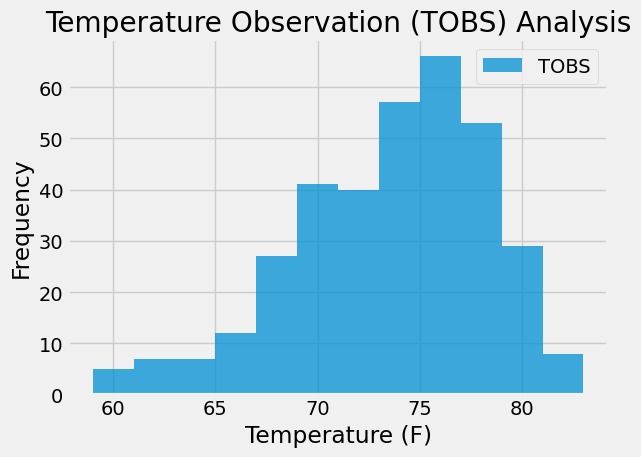

In [25]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_data = session.query(Measurement.date, Measurement.tobs)\
                   .filter(Measurement.station == most_active_station_id)\
                   .filter(Measurement.date >= one_year_ago_date_str)\
                   .filter(Measurement.date <= most_recent_date).all()


tobs_df = pd.DataFrame(tobs_data, columns=['Date', 'TOBS'])

# Plot the results as a histogram
plt.hist(tobs_df['TOBS'], bins=12, alpha=0.75)
plt.title("Temperature Observation (TOBS) Analysis")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.legend(["TOBS"], loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


# Close Session

In [26]:
# Close Session
session.close()